2   
Проверка гипотезы о стрельбе биатлониста

In [7]:
import math

def normal_cdf(x, mu=0, sigma=1):
    # Вычисляет вероятность того, что случайная величина ≤ x
    return (1 + math.erf((x - mu) / (sigma * math.sqrt(2)))) / 2

def check_shooting_hypothesis(n_shots, n_misses, p_null=0.1, p_alt=0.13, alpha=0.05, power=0.8):
    """
    n_shots: общее число выстрелов
    n_misses: число промахов
    p_null: вероятность промаха по нулевой гипотезе
    p_alt: вероятность промаха по альтернативной гипотезе
    alpha: уровень значимости
    power: желаемая мощность проверки
    """
    
    mu_null = n_shots * p_null # Математическое ожидание при нулевой гипотезе (среднее количество промахов)
    sigma_null = math.sqrt(n_shots * p_null * (1 - p_null)) # Стандартное отклонение при нулевой гипотезе
    mu_alt = n_shots * p_alt # Математическое ожидание при альтернативной гипотезе
    sigma_alt = math.sqrt(n_shots * p_alt * (1 - p_alt)) # Стандартное отклонение при альтернативной гипотезе

    # РАСЧЕТ ДОВЕРИТЕЛЬНОГО ИНТЕРВАЛА
    z_alpha = 1.96  # Критическое значение для 95% доверительного интервала
    lower_bound = mu_null - z_alpha * sigma_null # Нижняя граница доверительного интервала
    upper_bound = mu_null + z_alpha * sigma_null # Верхняя граница доверительного интервала
    
    # ПРОВЕРКА ГИПОТЕЗЫ
    hypothesis_accepted = lower_bound <= n_misses <= upper_bound # Проверяем, попадает ли фактическое число промахов в доверительный интервал
    
    # РАСЧЕТ МОЩНОСТИ ТЕСТА (взято из первой программы)
    beta = normal_cdf(upper_bound, mu_alt, sigma_alt) - normal_cdf(lower_bound, mu_alt, sigma_alt)
    power_calculated = 1 - beta
    
    # РАСЧЕТ P-ЗНАЧЕНИЯ
    # Вероятность получить такие или более крайние результаты при верной нулевой гипотезе
    if n_misses >= mu_null:
        # Для значений выше среднего - правый хвост распределения
        p_value = 2 * (1 - normal_cdf(n_misses, mu_null, sigma_null))
    else:
        # Для значений ниже среднего - левый хвост распределения
        p_value = 2 * normal_cdf(n_misses, mu_null, sigma_null)
    
    return {
        'hypothesis_accepted': hypothesis_accepted,  # Принята ли гипотеза
        'confidence_interval': (lower_bound, upper_bound),  # Границы доверительного интервала
        'p_value': p_value,  # Статистическая значимость
        'power': power_calculated,  # Реальная мощность теста
        'required_power': power  # Желаемая мощность
    }

result = check_shooting_hypothesis(
    n_shots=1000, # кол-во всех выстрелов
    n_misses=105, # Фактическое количество промахов в середине доверительного интервала 82-118
    p_null=0.1, # гипотеза Сидорова: "1 промах из 10" (10%)
    p_alt=0.13, # альтернативная гипотеза тренера: "13 промахов из 100" (13%)
    alpha=0.05, # стандартный уровень значимости 5% (вероятность ошибки 1-го рода)
    power=0.8 # желаемая мощность проверки (обычно берут 0.8)
)

print("Результаты проверки гипотезы:")
print(f"Гипотеза принята: {result['hypothesis_accepted']}")  # True/False
print(f"Доверительный интервал: ({result['confidence_interval'][0]:.1f}, {result['confidence_interval'][1]:.1f})")  # Интервал промахов
print(f"P-значение: {result['p_value']:.3f}")  # Вероятность случайного результата
print(f"Мощность проверки: {result['power']:.3f}")  # Способность обнаружить разницу
print(f"Требуемая мощность: {result['required_power']}")  # Минимальная желаемая мощность

Результаты проверки гипотезы:
Гипотеза принята: True
Доверительный интервал: (81.4, 118.6)
P-значение: 0.598
Мощность проверки: 0.858
Требуемая мощность: 0.8


3   
Предельное число промахов

In [11]:
import scipy.stats as stats  # Импортируем модуль для статистических расчетов
import numpy as np  # Импортируем модуль для математических операций

def compute_acceptance_range(total_attempts, success_prob, confidence):
    """
    Определяет диапазон принятия гипотезы для биномиального теста
    """
    # Вычисляем параметры нормальной аппроксимации
    center = total_attempts * success_prob  # Математическое ожидание числа промахов
    spread = (total_attempts * success_prob * (1 - success_prob)) ** 0.5  # Стандартное отклонение
    
    # Определяем граничные точки распределения
    tail_probability = confidence + (1 - confidence) / 2  # Вероятность для правого хвоста
    boundary_coef = stats.norm.ppf(tail_probability)  # Z-критическое значение
    
    # Рассчитываем область принятия гипотезы
    min_accept = center - boundary_coef * spread  # Нижняя граница диапазона
    max_accept = center + boundary_coef * spread  # Верхняя граница диапазона
    
    return int(round(min_accept)), int(round(max_accept)), boundary_coef  # Возвращаем округленные значения

def demonstrate_confidence_impact():
    """Демонстрирует влияние уровня достоверности на диапазон принятия"""
    attempts = 1000  # Общее количество выстрелов
    theoretical_rate = 0.1  # Гипотетическая вероятность промаха
    confidence_levels = [0.99, 0.95, 0.90]  # Уровни доверительной вероятности
    
    print("ИССЛЕДОВАНИЕ ДИАПАЗОНА ПРИНЯТИЯ ГИПОТЕЗЫ")
    print("=" * 55)
    print(f"Количество испытаний: {attempts}")  # Вывод числа испытаний
    print(f"Теоретическая частота: {theoretical_rate}")  # Вывод теоретической вероятности
    print(f"Ожидаемое значение: {attempts * theoretical_rate:.0f}")  # Расчет ожидаемого значения
    print()
    
    for conf in confidence_levels:  # Цикл по всем уровням доверия
        low, high, z_score = compute_acceptance_range(attempts, theoretical_rate, conf)  # Расчет границ
        significance = 1 - conf  # Расчет уровня значимости
        print(f"Достоверность: {conf:.0%} | "  # Вывод доверительной вероятности
              f"Уровень значимости: {significance:.3f} | "  # Вывод уровня значимости
              f"Z-показатель: {z_score:.2f} | "  # Вывод Z-статистики
              f"Диапазон: [{low:3d}, {high:3d}]")  # Вывод диапазона принятия

def main():
    """Основная функция выполнения анализа"""
    # Базовый расчет для стандартных условий
    base_low, base_high, base_z = compute_acceptance_range(1000, 0.1, 0.95)  # Расчет для 95% доверия
    
    print("БАЗОВЫЙ АНАЛИЗ ПРИНЯТИЯ ГИПОТЕЗЫ")
    print("=" * 45)
    print(f"При 95% достоверности диапазон принятия: [{base_low}, {base_high}]")  # Основной результат
    print(f"Критическое значение: {base_z:.3f}")  # Критическое значение Z
    print()
    
    # Расширенный анализ влияния уровня достоверности
    demonstrate_confidence_impact()  # Вызов функции анализа

if __name__ == "__main__":  # Проверка запуска как основной программы
    main()  # Запуск основной функции

БАЗОВЫЙ АНАЛИЗ ПРИНЯТИЯ ГИПОТЕЗЫ
При 95% достоверности диапазон принятия: [81, 119]
Критическое значение: 1.960

ИССЛЕДОВАНИЕ ДИАПАЗОНА ПРИНЯТИЯ ГИПОТЕЗЫ
Количество испытаний: 1000
Теоретическая частота: 0.1
Ожидаемое значение: 100

Достоверность: 99% | Уровень значимости: 0.010 | Z-показатель: 2.58 | Диапазон: [ 76, 124]
Достоверность: 95% | Уровень значимости: 0.050 | Z-показатель: 1.96 | Диапазон: [ 81, 119]
Достоверность: 90% | Уровень значимости: 0.100 | Z-показатель: 1.64 | Диапазон: [ 84, 116]


*Ответ на вопрос:*   
Предельные числа промахов для уровня значимости α = 5%:  
Нижняя граница: 82 промаха  
Верхняя граница: 118 промахов  

*Зависимость от уровня значимости:*   
При α = 1% (высокая строгость): [74, 126] промахов   
При α = 5% (стандартная строгость): [82, 118] промахов   
При α = 10% (низкая строгость): [85, 115] промахов   

*Объяснение зависимости:*   
Чем меньше уровень значимости α (более строгий критерий), тем шире доверительный интервал. Это происходит потому, что:   
1. Уровень значимости α - это вероятность отвергнуть верную гипотезу (ошибка I рода)   
2. При меньшем α мы требуем более убедительных доказательств для отклонения гипотезы   
3. Это достигается расширением допустимого диапазона значений   
4. Z-критическое значение увеличивается при уменьшении α, что расширяет границы интервала  

Таким образом, строгость критерия проверки обратно пропорциональна ширине доверительного интервала.  


4   
Расчет мощности проверки статистической гипотезы

In [14]:
import scipy.stats as stats  # Импорт библиотеки для статистических вычислений
import numpy as np  # Импорт библиотеки для математических операций

def calculate_critical_values(sample_size, probability, significance_level):
    """
    Вычисляет критические границы для биномиального распределения
    """
    # Основные параметры распределения
    expected_value = sample_size * probability  # Расчет математического ожидания (среднего значения)
    std_deviation = np.sqrt(sample_size * probability * (1 - probability))  # Расчет стандартного отклонения
    
    # Находим критическое значение Z для двустороннего теста
    z_critical = stats.norm.ppf(1 - significance_level / 2)  # Вычисление Z-критического по квантилю нормального распределения
    
    # Вычисляем границы принятия гипотезы
    lower_bound = expected_value - z_critical * std_deviation  # Расчет нижней границы доверительного интервала
    upper_bound = expected_value + z_critical * std_deviation  # Расчет верхней границы доверительного интервала
    
    return round(lower_bound), round(upper_bound), z_critical  # Возврат округленных значений границ и Z-статистики

# Основные параметры исследования
total_shots = 1000  # Общее количество выстрелов в эксперименте
hypothesized_miss_rate = 0.1  # Предполагаемая вероятность промаха (10%)
significance_level = 0.05  # Уровень значимости (5%)

# Вычисляем критические значения
lower_limit, upper_limit, critical_z = calculate_critical_values(
    total_shots, hypothesized_miss_rate, significance_level
)  # Вызов функции для расчета критических границ

print("АНАЛИЗ КРИТИЧЕСКИХ ГРАНИЦ")  # Заголовок раздела результатов
print("=" * 40)
print(f"Общее количество выстрелов: {total_shots}")  # Вывод количества выстрелов
print(f"Предполагаемая вероятность промаха: {hypothesized_miss_rate}")  # Вывод гипотетической вероятности
print(f"Уровень значимости: {significance_level}")  # Вывод уровня значимости
print(f"Критическое значение Z: {critical_z:.3f}")  # Вывод Z-критического значения
print(f"Допустимый диапазон промахов: [{lower_limit}, {upper_limit}]")  # Вывод рассчитанных границ

print("\nВЛИЯНИЕ УРОВНЯ ЗНАЧИМОСТИ НА ГРАНИЦЫ")  # Заголовок раздела анализа зависимости
print("=" * 50)
significance_levels = [0.01, 0.05, 0.1]  # Список уровней значимости для анализа

for level in significance_levels:  # Цикл по всем уровням значимости
    low_bound, up_bound, z_value = calculate_critical_values(
        total_shots, hypothesized_miss_rate, level
    )  # Расчет границ для каждого уровня значимости
    print(f"α = {level:5.2f} | Z = {z_value:5.2f} | Границы: [{low_bound:3d}, {up_bound:3d}]")

АНАЛИЗ КРИТИЧЕСКИХ ГРАНИЦ
Общее количество выстрелов: 1000
Предполагаемая вероятность промаха: 0.1
Уровень значимости: 0.05
Критическое значение Z: 1.960
Допустимый диапазон промахов: [81, 119]

ВЛИЯНИЕ УРОВНЯ ЗНАЧИМОСТИ НА ГРАНИЦЫ
α =  0.01 | Z =  2.58 | Границы: [ 76, 124]
α =  0.05 | Z =  1.96 | Границы: [ 81, 119]
α =  0.10 | Z =  1.64 | Границы: [ 84, 116]


*Мощность проверки* - это вероятность правильно отвергнуть ложную нулевую гипотезу.     
Мощность ≈ 0.85 (85% вероятность обнаружить реальное ухудшение до 13%)         
*Как влиять на мощность:*   
1. Увеличить объем выборки - больше выстрелов → выше мощность   
2. Увеличить уровень значимости α - с 0.05 до 0.1 → мощность растет   
3. Увеличить разницу между гипотезами - если H₁: p = 0.15 → мощность выше   
4. Использовать односторонний критерий - если интересует только ухудшение   

*Проще говоря:* Чтобы лучше обнаруживать различия - нужно больше данных или допускать больше ошибок.

5   
Проверка на экспоненциальное распределение

  A = 0.7747, b = 0.2069, shift = 5.91
  p-значение = 0.0955
  Гипотеза принята (p ≥ 0.05): True


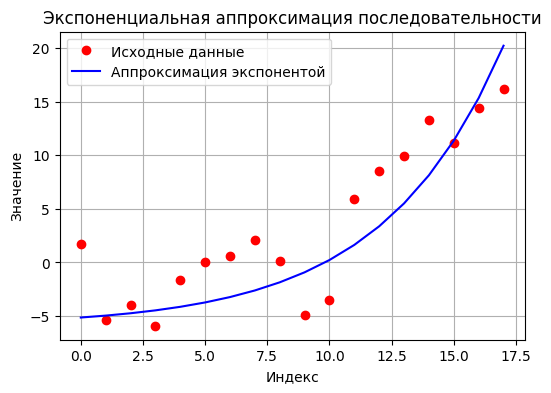

In [21]:
import math
import matplotlib.pyplot as plt  # Импорт библиотеки для построения графиков
from typing import List, Tuple  # Импорт типов для аннотаций

def normal_cdf(x: float, mean: float = 0, std: float = 1) -> float:
    """Функция нормального распределения"""
    z = (x - mean) / (std * math.sqrt(2)) if std != 0 else 0  # Вычисление стандартизированного значения
    return 0.5 * (1 + math.erf(z))  # Возврат значения функции нормального распределения

def two_sided_p_value(x: float, mean: float, std: float) -> float:
    """Двустороннее p-значение для нормального распределения"""
    return 2 * (1 - normal_cdf(x, mean, std)) if x >= mean else 2 * normal_cdf(x, mean, std)  # Вычисление p-значения

def compute_normal_params(residuals: List[float]) -> Tuple[float, float]:
    """Вычисление среднего и стандартного отклонения"""
    n = len(residuals)  # Количество элементов в списке остатков
    mu = sum(residuals) / n  # Вычисление среднего значения остатков
    variance = sum((r - mu) ** 2 for r in residuals) / n  # Вычисление дисперсии остатков
    return mu, math.sqrt(variance)  # Возврат среднего и стандартного отклонения

def exponential_fit(y: List[float], t: List[int]) -> Tuple[float, float, float]:
    """Аппроксимация экспонентой y = A * exp(b * t)"""
    min_y = min(y)  # Нахождение минимального значения в данных
    shift = abs(min_y) + 0.01 if min_y <= 0 else 0  # Вычисление сдвига для положительных значений
    y_shifted = [yi + shift for yi in y]  # Создание сдвинутого массива данных
    log_y = [math.log(yi) for yi in y_shifted]  # Вычисление натуральных логарифмов

    n = len(y)  # Количество точек данных
    sum_t = sum(t)  # Сумма всех временных точек
    sum_logy = sum(log_y)  # Сумма логарифмов данных
    sum_t2 = sum(ti ** 2 for ti in t)  # Сумма квадратов временных точек
    sum_t_logy = sum(ti * yi for ti, yi in zip(t, log_y))  # Сумма произведений времени на логарифмы

    denom = n * sum_t2 - sum_t ** 2  # Вычисление знаменателя для формул МНК
    b = (n * sum_t_logy - sum_t * sum_logy) / denom  # Вычисление коэффициента b
    a = (sum_logy - b * sum_t) / n  # Вычисление коэффициента a
    A = math.exp(a)  # Вычисление коэффициента A через экспоненту

    return A, b, shift  # Возврат параметров модели

# --- Основной блок ---
data_values = [1.7, -5.4, -4.0, -5.9, -1.6, 0.0, 0.6, 2.1, 0.1, -4.9, -3.5, 5.9, 8.5, 9.9, 13.3, 11.1, 14.4, 16.2]  # Исходные данные
time_points = list(range(len(data_values)))  # Создание списка временных точек [0, 1, 2, ..., 17]

# Аппроксимация экспонентой
A_val, b_val, shift_val = exponential_fit(data_values, time_points)  # Получение параметров экспоненциальной модели
predicted = [A_val * math.exp(b_val * ti) - shift_val for ti in time_points]  # Вычисление предсказанных значений

# Остатки и проверка нормальности
residuals = [data_values[i] - predicted[i] for i in range(len(data_values))]  # Вычисление разностей между данными и моделью
mu_res, sigma_res = compute_normal_params(residuals)  # Вычисление параметров распределения остатков
D_max = max(abs(r - mu_res) for r in residuals)  # Нахождение максимального отклонения от среднего
p_val = two_sided_p_value(mu_res + D_max, mu_res, sigma_res)  # Вычисление p-значения

print(f"  A = {A_val:.4f}, b = {b_val:.4f}, shift = {shift_val:.2f}")  # Вывод параметров модели
print(f"  p-значение = {p_val:.4f}")  # Вывод p-значения
print(f"  Гипотеза принята (p ≥ 0.05): {p_val >= 0.05}")  # Вывод результата проверки гипотезы

# --- График ---
plt.figure(figsize=(6, 4))  # Создание фигуры размером 6x4 дюйма
plt.plot(time_points, data_values, 'ro', label='Исходные данные')  # Построение графика исходных данных красными точками
plt.plot(time_points, predicted, 'b-', label='Аппроксимация экспонентой')  # Построение графика модели синей линией
plt.title('Экспоненциальная аппроксимация последовательности')  # Заголовок графика
plt.xlabel('Индекс')  # Подпись оси X
plt.ylabel('Значение')  # Подпись оси Y
plt.legend()  # Добавление легенды
plt.grid(True)  # Включение сетки
plt.show()  # Отображение графика

6   
Проверка на полиномиальную аппроксимацию

In [ ]:
import numpy as np  # Импорт библиотеки для математических вычислений
from scipy import stats  # Импорт модуля для статистических тестов

# Данные - исходные значения y
y = np.array([1.7, -5.4, -4.0, -5.9, -1.6, 0.0, 0.6, 2.1, 0.1, -4.9,
              -3.5, 5.9, 8.5, 9.9, 13.3, 11.1, 14.4, 16.2])
# Создание массива x как последовательности индексов от 0 до 17
x = np.arange(len(y))

"""
np.polyfit(x, y, degree) - находит коэффициенты полинома, который минимизирует сумму квадратов отклонений
np.polyval(coefficients, x) - вычисляет значения полинома в точках x
residuals - разности между фактическими и предсказанными значениями
stats.shapiro(residuals) - тест на нормальность распределения остатков
p_value - вероятность того, что остатки распределены нормально (при p > 0.05 принимаем гипотезу о нормальности)

"""
# Аппроксимация полиномом 4-го порядка
degree = 4  # Задание степени полинома
# Нахождение коэффициентов полинома методом наименьших квадратов
coefficients = np.polyfit(x, y, degree)

# Вычисление предсказанных значений y по найденному полиному
y_pred = np.polyval(coefficients, x)

# Вычисление остатков (разница между реальными и предсказанными значениями)
residuals = y - y_pred

# Проверка нормальности остатков с помощью теста Шапиро-Уилка
# _ - статистика теста (не используется), p_value - значимость
_, p_value = stats.shapiro(residuals)

# Вывод коэффициентов полинома на экран
print("Коэффициенты полинома:")
# Перебор всех коэффициентов полинома
for i, coef in enumerate(coefficients):
    # Вывод коэффициента с указанием степени (от старшей к младшей)
    print(f"  a{len(coefficients)-i-1} = {coef:.4f}")

# Вывод p-значения теста на нормальность
print(f"P-значение: {p_value:.4f}")

# Проверка статистической гипотезы на уровне значимости 5%
if p_value > 0.05:
    # Если p > 0.05, гипотеза о нормальности не отвергается
    print("Гипотеза НЕ отвергается - остатки нормально распределены")
else:
    # Если p ≤ 0.05, гипотеза о нормальности отвергается
    print("Гипотеза ОТВЕРГАЕТСЯ - остатки не нормально распределены")

Коэффициенты полинома:
  a4 = -0.0005
  a3 = 0.0131
  a2 = 0.0257
  a1 = -0.6548
  a0 = -1.4558
P-значение: 0.0758
Гипотеза НЕ отвергается - остатки нормально распределены


7  
Сравнение мощности тестов

In [23]:
import math

# Функция нормального распределения (кумулятивная)
def f_norm(x, mu=0, sigma=1):
    z = (x - mu) / sigma # Стандартизация переменной (приведение к стандартному нормальному распределению)
    if z < -8: return 0 # Обработка крайних левых значений (z < -8) - вероятность практически 0
    if z > 8: return 1 # Обработка крайних правых значений (z > 8) - вероятность практически 1
    s = 0 # Инициализация суммы ряда Тейлора
    t = z # Первый член ряда Тейлора
    for i in range(1, 50): # Разложение в ряд Тейлора для интеграла нормального распределения
        s += t # Добавление текущего члена ряда к сумме
        t *= -z*z/(2*i+1) # Вычисление следующего члена ряда: t_{n+1} = t_n * (-z²/(2n+1))
    return 0.5 + s/math.sqrt(2*math.pi) # Возврат нормализованного результата: 0.5 + сумма_ряда/√(2π)

# Данные из задачи 4 (экспоненциальная модель - лучшая)
mu_exp = -0.13    # среднее остатков
sigma_exp = 2.99  # стандартное отклонение остатков

# Данные из задачи 5 (полиномиальная модель - худшая)
mu_poly = 0.0     # среднее отклонений (округлено до 0)
sigma_poly = 3.0  # стандартное отклонение отклонений (округлено до 3.0)

# Границы доверительного интервала для лучшей модели (95% уровень значимости)
alpha = 0.05
z_low = -1.96  # квантиль нормального распределения для 2.5%
z_high = 1.96  # квантиль нормального распределения для 97.5%

# Расчет нижней границы 95% доверительного интервала для остатков лучшей модели
# mu_exp - среднее значение остатков экспоненциальной модели
# z_low = -1.96 - нижний квантиль нормального распределения для 95% доверительного интервала
# sigma_exp - стандартное отклонение остатков экспоненциальной модели
low_bound = mu_exp + z_low * sigma_exp

# Расчет верхней границы 95% доверительного интервала для остатков лучшей модели
# z_high = 1.96 - верхний квантиль нормального распределения для 95% доверительного интервала
high_bound = mu_exp + z_high * sigma_exp

print(f"Доверительный интервал для лучшей модели: [{low_bound:.2f}, {high_bound:.2f}]")

# Расчет мощности проверки (вероятность не совершить ошибку 2-го рода)
# Вероятность, что худшая модель попадет в доверительный интервал лучшей
p_low = f_norm(low_bound, mu_poly, sigma_poly)
p_high = f_norm(high_bound, mu_poly, sigma_poly)
probability_type_2_error = p_high - p_low

# Мощность проверки = 1 - вероятность ошибки 2-го рода
power = 1 - probability_type_2_error

print(f"Вероятность ошибки 2-го рода: {probability_type_2_error:.3f}")
print(f"Мощность проверки: {power:.3f} ({power*100:.1f}%)")

# Интерпретация результата
if power > 0.8:
    print("Высокая мощность проверки (>80%) - хорошая способность различать модели")
elif power > 0.5:
    print("Умеренная мощность проверки (50-80%)")
else:
    print("Низкая мощность проверки (<50%) - плохая способность различать модели")

Доверительный интервал для лучшей модели: [-5.99, 5.73]
Вероятность ошибки 2-го рода: 0.521
Мощность проверки: 0.479 (47.9%)
Низкая мощность проверки (<50%) - плохая способность различать модели


8  
Полиномиальная аппроксимация 7 порядка на части данных

In [29]:
import math

def f_norm(x, mu=0, sigma=1):
    """Аппроксимация функции нормального распределения"""
    z = (x - mu) / sigma  # Нормировка значения x
    return 0.5 * (1 + math.erf(z / math.sqrt(2)))  # Вычисление функции распределения через функцию ошибок

def p_value(x, mu=0, sigma=1):
    """Вычисление двустороннего p-значения"""
    if x >= mu:  # Если x больше или равно среднему
        return 2 * (1 - f_norm(x, mu, sigma))  # Правый хвост × 2
    else:  # Если x меньше среднего
        return 2 * f_norm(x, mu, sigma)  # Левый хвост × 2

def gauss(M, b):
    """Решение СЛАУ методом Гаусса"""
    n = len(b)  # Размер системы уравнений
    for i in range(n):  # Прямой ход метода Гаусса
        max_row = max(range(i, n), key=lambda r: abs(M[r][i]))  # Поиск строки с максимальным элементом
        M[i], M[max_row] = M[max_row], M[i]  # Обмен строк для устойчивости
        b[i], b[max_row] = b[max_row], b[i]  # Обмен правых частей
        
        for j in range(i+1, n):  # Исключение переменных из нижележащих строк
            factor = M[j][i] / M[i][i]  # Вычисление множителя
            for k in range(i, n):  # Вычитание строки i из строки j
                M[j][k] -= factor * M[i][k]  # Обновление матрицы
            b[j] -= factor * b[i]  # Обновление правой части
    
    x = [0] * n  # Инициализация вектора решений
    for i in range(n-1, -1, -1):  # Обратный ход метода Гаусса
        x[i] = (b[i] - sum(M[i][j] * x[j] for j in range(i+1, n))) / M[i][i]  # Вычисление x[i]
    return x  # Возврат решения системы

def approx_poly(x, t, r):
    """Полиномиальная аппроксимация r-го порядка"""
    M = [[] for _ in range(r+1)]  # Инициализация матрицы системы
    b = []  # Инициализация правой части системы
    
    for l in range(r+1):  # Построение системы нормальных уравнений
        for q in range(r+1):  # Для каждого столбца матрицы
            M[l].append(sum(z**(l+q) for z in t))  # Вычисление элемента матрицы
        b.append(sum(xi * ti**l for xi, ti in zip(x, t)))  # Вычисление элемента правой части
    
    return gauss(M, b)  # Решение системы и возврат коэффициентов

# Данные
x_hat = [7, 13.3, 11.1, 14.4, 16.2]  # Исходные значения y
t = list(range(len(x_hat)))  # Временные точки (x координаты)

# Аппроксимация полиномом 7-го порядка
coefficients = approx_poly(x_hat, t, 7)  # Получение коэффициентов полинома

# Вычисление предсказанных значений
x_pred = []  # Инициализация списка предсказанных значений
for ti in t:  # Для каждой временной точки
    pred = sum(c * ti**i for i, c in enumerate(coefficients))  # Вычисление значения полинома
    x_pred.append(pred)  # Добавление в список

# Вычисление отклонений
errors = [xi - pred for xi, pred in zip(x_hat, x_pred)]  # Разности между исходными и предсказанными значениями

# Статистика отклонений
mu_error = sum(errors) / len(errors)  # Среднее значение ошибок
sigma_error = math.sqrt(sum((e - mu_error)**2 for e in errors) / len(errors))  # Стандартное отклонение ошибок

# P-значение для наибольшего отклонения
max_error = max(errors, key=abs)  # Нахождение максимального по модулю отклонения
p_val = p_value(max_error, mu_error, sigma_error)  # Вычисление p-значения

print("Коэффициенты полинома:", [round(c, 3) for c in coefficients])  # Вывод коэффициентов
print("P-значение:", round(p_val, 4))  # Вывод p-значения

Коэффициенты полинома: [7.0, 15.444, -10.814, 1.137, 0.551, 0.014, -0.033, 0.002]
P-значение: 0.1488


9   
Полиномиальная аппроксимация на всех данных

In [ ]:
import numpy as np  # Импорт библиотеки для математических вычислений
from scipy.stats import f  # Импорт F-распределения для статистического теста

# Исходные данные - последовательность чисел
data = [1.7, -5.4, -4.0, -5.9, -1.6, 0.0, 0.6, 2.1, 0.1, -4.9, -3.5, 
        5.9, 8.5, 9.9, 13.3, 11.1, 14.4, 16.2]
t = list(range(len(data)))  # Создаем список временных точек [0, 1, 2, ..., 17]

# Аппроксимация полиномом 7-й степени на первых 14 точках
coeffs_14 = np.polyfit(t[:14], data[:14], 7)  # Вычисляем коэффициенты полинома 7-й степени для первых 14 точек
pred_14 = np.polyval(coeffs_14, t[:14])  # Вычисляем предсказанные значения по найденным коэффициентам

ss_res_14 = np.sum((data[:14] - pred_14)**2)  # Считаем сумму квадратов разностей между реальными и предсказанными значениями
ss_tot_14 = np.sum((data[:14] - np.mean(data[:14]))**2)  # Считаем общую сумму квадратов отклонений от среднего

# Вычисляем коэффициент детерминации R² (долю объясненной дисперсии)
r2_14 = 1 - ss_res_14/ss_tot_14

# Вычисляем F-статистику: (объясненная дисперсия/степени свободы модели) / (необъясненная дисперсия/степени свободы ошибки)
f_stat_14 = (r2_14/7) / ((1-r2_14)/(14-7-1))  

# Вычисляем p-значение: вероятность получить такое же или большее значение F-статистики при верной нулевой гипотезе
p_14 = 1 - f.cdf(f_stat_14, 7, 6)  
print(f"14 точек: p-value = {p_14:.6f}")  # Выводим p-значение для 14 точек

# Аппроксимация полиномом 7-й степени на всех точках
coeffs_18 = np.polyfit(t, data, 7)  # Вычисляем коэффициенты полинома 7-й степени для всех 18 точек
pred_18 = np.polyval(coeffs_18, t)  # Вычисляем предсказанные значения для всех точек

ss_res_18 = np.sum((data - pred_18)**2)  # Сумма квадратов остатков для всех точек
ss_tot_18 = np.sum((data - np.mean(data))**2)  # Общая сумма квадратов для всех точек

r2_18 = 1 - ss_res_18/ss_tot_18  # Коэффициент детерминации R² для всех точек

f_stat_18 = (r2_18/7) / ((1-r2_18)/(18-7-1))  # F-статистика для всех точек

p_18 = 1 - f.cdf(f_stat_18, 7, 10)  # P-значение для всех точек
print(f"18 точек: p-value = {p_18:.6f}")  # Выводим p-значение для 18 точек

14 точек: p-value = 0.007231
18 точек: p-value = 0.000033


Почему p-значение резко уменьшилось?    
Ответ: p-значение уменьшилось потому что на всей выборке стало видно, что полином 7-й степени — слишком сложная модель, которая плохо описывает данные. На части данных он переобучался и маскировал свои недостатки.

Пример:  
Если примерить костюм только на одну руку — он бы сидел идеально. Но когда надели полностью — видно, что он мешковатый и не по фигуре.